# fig — recon

**Motivation**: host = ```mach```, device = ```cuda:2``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from analysis.chosen import *
from figures.analysis import *

device_idx = 2
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:2  ———  host: mach

In [3]:
fig_dir = pjoin(fig_base_dir, 'iclr_oct02', 'recon')
os.makedirs(fig_dir, exist_ok=True)
print(os.listdir(fig_dir))

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

['recon_src-MNIST_tgt-MNIST', 'recon_src-MNIST_tgt-Omniglot']

In [4]:
alt_models_dir = 'Dropbox/git/jb-vae/tmp/dekel_data/rot_full'

In [13]:
across_files

['MARINO_hierarchical_from-mnist-to-omniglot_MNIST_H_iters10_full.npz',
 'MARINO_single_level_from-mnist-to-omniglot_MNIST_SL_iters10_full.npz',
 'SAVAE_from-mnist-to-omniglot_iter20_full.npz']

In [14]:
within_files

['MARINO_mnist_hierarchical_iterative_MNIST_H_10_full.npz',
 'MARINO_mnist_single_level_iterative_MNIST_SL_10_full.npz',
 'SAVAE_mnist_iter20_full.npz']

In [16]:
f = within_files[0]
load = dict(np.load(
    pjoin(load_dir, f),
    allow_pickle=True,
))

In [17]:
list(load)

['posteriors_val', 'recons_val', 'recons_trn', 'posteriors_trn']

In [19]:
load['recons_val'].shape

(10000, 1, 28, 28)

## iP-VAE

In [4]:
models_to_load = selected_models_28x28(device, full=True)
models_to_load = {
    m: d for m, d in
    models_to_load.items() if (
        m.startswith('MNIST')
        and 'jacob' in m
    )
}
models_to_load = dict(sorted(
    models_to_load.items(),
    key=lambda t: alphanum_sort_key(t[0]),
))
print(list(models_to_load))

[
    'MNIST_<jacob|conv>_(16,8.0)',
    'MNIST_<jacob|conv>_(4,1.5)',
    'MNIST_<jacob|mlp>_(16,8.0)',
    'MNIST_<jacob|mlp>_(4,1.5)',
    'MNIST_<jacob|mlp>_(64,24.0)'
]

In [5]:
trainers = {}
for name, kwargs in tqdm(models_to_load.items()):
    trainers[name] = load_model(**kwargs)[0]

100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.87it/s]


## Save recon figs

In [6]:
inds = get_shuffle_inds('MNIST')
print(inds)

{'MNIST': array([ 0,  1,  2,  3,  4,  7,  8, 11, 18, 61])}

In [7]:
def _save_fig():
    fig_base_name = f'recon-MNIST_{name}'
    
    x2p = np.concatenate([tonp(x)] + recon)
    fig, ax = plot_weights(x2p, nrows=len(recon) + 1, cmap='Greys', method='none', vmin=0.001, vmax=1.0, dpi=50)
    fig_name = pjoin(fig_dir, f"{fig_base_name}.png")
    fig.savefig(fig_name, **kws_fig)

    for row in [True, False]:
        row_col_str = 'row' if row else 'col'
        
        fig, ax = plot_row_or_col(x, row=row, display=False)
        fig_name = f"{fig_base_name}_{row_col_str}-input.png"
        fig_name = pjoin(fig_dir, fig_name)
        fig.savefig(fig_name, **kws_fig)

        for t in [0, 9, 99, 999]:
            x2p = tonp(output['recon'][:, t, :])
            x2p = x2p.reshape(tr.model.cfg.shape)

            fig, ax = plot_row_or_col(x2p, row=row, display=False)
            fig_name = f"{fig_base_name}_{row_col_str}-t={t}.png"
            fig_name = pjoin(fig_dir, fig_name)
            fig.savefig(fig_name, **kws_fig)

______________________________________________________________________________________________________________

MNIST_<jacob|conv>_(16,8.0)

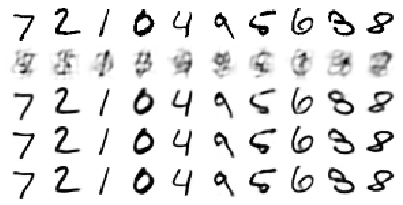

______________________________________________________________________________________________________________

MNIST_<jacob|conv>_(4,1.5)

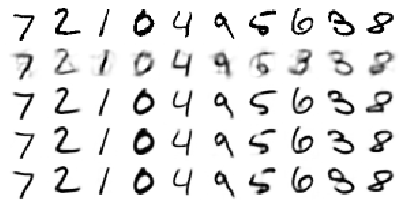

______________________________________________________________________________________________________________

MNIST_<jacob|mlp>_(16,8.0)

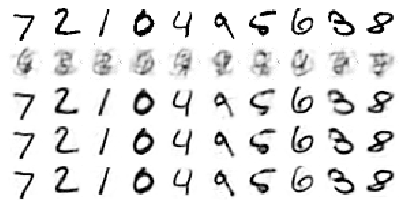

______________________________________________________________________________________________________________

MNIST_<jacob|mlp>_(4,1.5)

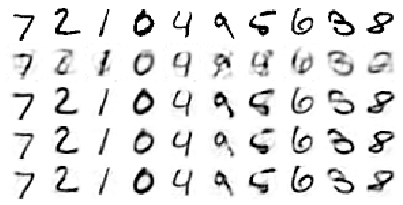

______________________________________________________________________________________________________________

MNIST_<jacob|mlp>_(64,24.0)

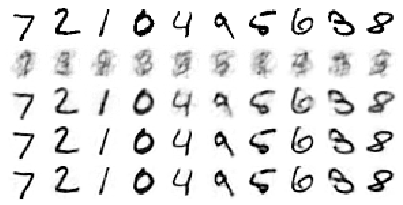

CPU times: user 1min 18s, sys: 4.83 s, total: 1min 23s
Wall time: 1min 10s


In [8]:
%%time


for name, tr in trainers.items():
    x = tr.dl_vld.dataset.tensors[0][inds['MNIST']]
    output = tr.model.xtract_ftr(
        x=x,
        seq=range(1000),
        return_extras=True,
    ).stack()
    
    recon = [output['recon'][:, t, :] for t in [0, 9, 99, 999]]
    recon = [tonp(e).reshape(tr.model.cfg.shape) for e in recon]
    
    print('_' * 110)
    print(name)

    # save figs
    _save_fig()

    print('\n\n')

## Recon: Marino & Kim

### Prep to load

In [9]:
dekel_dir = '/home/hadi/Dropbox/git/jb-vae/tmp/dekel_data/rot_full'

dekel_files = sorted(
    os.listdir(dekel_dir),
    key=alphanum_sort_key,
)
selected_dekel_files = [
    f for f in dekel_files
    if 'rotate' not in f
    and 'from' not in f
    and '_mnist' in f
]
print(selected_dekel_files)

[
    'MARINO_mnist_hierarchical_iterative_MNIST_H_10_full.npz',
    'MARINO_mnist_single_level_iterative_MNIST_SL_10_full.npz',
    'SAVAE_mnist_iter20_full.npz'
]

### Load and save figs

In [10]:
def _save_fig():
    fig_base_name = f'recon-MNIST_{name}'

    for row in [True, False]:
        row_col_str = 'row' if row else 'col'

        fig, ax = plot_row_or_col(x2p, row=row, display=row)
        fig_name = f"{fig_base_name}_{row_col_str}-t=final.png"
        fig_name = pjoin(fig_dir, fig_name)
        fig.savefig(fig_name, **kws_fig)

______________________________________________________________________________________________________________

MARINO~mnist~hierarchical~iterative~MNIST~H~10

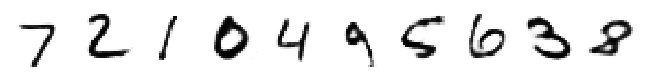

______________________________________________________________________________________________________________

MARINO~mnist~single~level~iterative~MNIST~SL~10

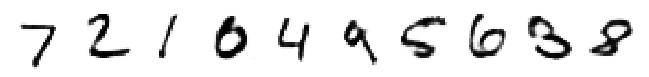

______________________________________________________________________________________________________________

SAVAE~mnist~iter20

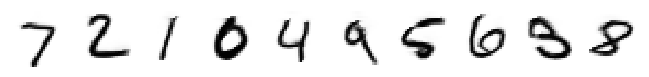

In [11]:
for f in selected_dekel_files:
    name = '~'.join(f.split('_')[:-1])
    load = dict(np.load(
        pjoin(dekel_dir, f),
        allow_pickle=True,
    ))
    x2p = load['recons_val'][inds['MNIST']]
    if np.nanmax(x2p) > 1:
        x2p /= 255

    print('_' * 110)
    print(name)

    # save figs
    _save_fig()

    print('\n\n')